In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
import re

In [2]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query("""SELECT * FROM Reviews""", con)
final.head()


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i bought sever vital can dog food product foun...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect around centuri it light pillowi c...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,if look secret ingredi robitussin i believ i f...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there wide assort yumm...


In [3]:
data = final[['Score', 'Time', 'CleanedText']].copy()
data.sort_values('Time', inplace = True)
data.head(10)

,Score,Time,CleanedText
117879,positive,939340800,witti littl book make son laugh loud recit car...
117856,positive,940809600,i rememb see show air televis year ago i child...
298565,positive,944092800,beetlejuic well written movi everyth excel fro...
169198,positive,944438400,a twist rumplestiskin captur film star michael...
298564,positive,946857600,beetlejuic excel funni movi keaton hilari wack...
169259,positive,947376000,this is one movi that should be in your movi c...
169184,negative,948240000,i alway enjoy movi funni entertain i didn hesi...
63292,positive,948672000,i bought apart infest fruit fli after hour tra...
169284,positive,951523200,what happen say name three time michael keaten...
298566,positive,959990400,i get crazi is realli imposs today not find fr...


In [4]:
data['Score'].value_counts()

positive    306779
negative     57078
Name: Score, dtype: int64

In [5]:
X = data['CleanedText']
y = data['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False, random_state = 100)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((254699,), (254699,), (109158,), (109158,))

In [6]:
vectr = TfidfVectorizer(ngram_range=(1,2),min_df=1)
vectr.fit(X_train)
vect_X = vectr.transform(X_train)

In [7]:
model = LogisticRegression()
clf=model.fit(vect_X,y_train)
c=vectr.transform(X_test)
y_pred = clf.predict(c)
accuracy_score(y_test,y_pred)

0.9289928360724821

In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.89      0.68      0.77     19066
    positive       0.93      0.98      0.96     90092

    accuracy                           0.93    109158
   macro avg       0.91      0.83      0.86    109158
weighted avg       0.93      0.93      0.93    109158



In [9]:
roc=roc_auc_score(y_test, clf.predict_proba(c)[:,1])
print("\n AUC for test data is", roc)


 AUC for test data is 0.9684000402721307


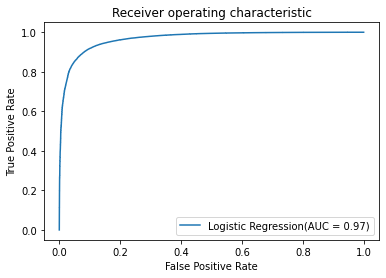

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(c)[:,1],pos_label = 'positive')
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression(AUC = %0.2f)' % roc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(vect_X, y_train)
y_pred_rf = model_rf.predict(c)



In [12]:
print('\n Confusion Matrix \n',confusion_matrix(y_pred_rf,y_test))
print("\n Accuracy of Random Forest: ",accuracy_score(y_test,y_pred_rf))
print(classification_report(y_test, y_pred_rf))


 Confusion Matrix 
 [[ 5046   657]
 [14020 89435]]

 Accuracy of Random Forest:  0.8655435240660327
              precision    recall  f1-score   support

    negative       0.88      0.26      0.41     19066
    positive       0.86      0.99      0.92     90092

    accuracy                           0.87    109158
   macro avg       0.87      0.63      0.67    109158
weighted avg       0.87      0.87      0.83    109158



In [13]:
roc=roc_auc_score(y_test, model_rf.predict_proba(c)[:,1])
print("\n AUC for test data is", roc)


 AUC for test data is 0.8613703971611542


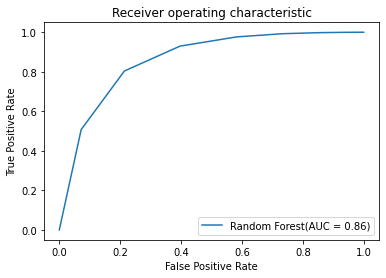

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, model_rf.predict_proba(c)[:,1],pos_label = 'positive')
plt.figure()
plt.plot(fpr, tpr, label='Random Forest(AUC = %0.2f)' % roc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
bow = CountVectorizer(ngram_range=(1,2),min_df=1)
bow.fit(X_train)
bow_X = bow.transform(X_train)



In [16]:
model = LogisticRegression()
clf=model.fit(bow_X,y_train)
c=bow.transform(X_test)
y_pred = clf.predict(c)
accuracy_score(y_test,y_pred)

0.9389417175103978

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.87      0.77      0.81     19066
    positive       0.95      0.98      0.96     90092

    accuracy                           0.94    109158
   macro avg       0.91      0.87      0.89    109158
weighted avg       0.94      0.94      0.94    109158



In [18]:
roc=roc_auc_score(y_test, clf.predict_proba(c)[:,1])
print("\n AUC for test data is", roc)


 AUC for test data is 0.9659485420288508


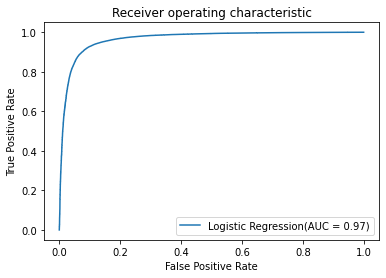

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(c)[:,1],pos_label = 'positive')
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression(AUC = %0.2f)' % roc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
model_rf = RandomForestClassifier()
model_rf.fit(bow_X, y_train)
y_pred_rf = model_rf.predict(c)

In [21]:
print('\n Confusion Matrix \n',confusion_matrix(y_pred_rf,y_test))
print("\n Accuracy of Random Forest: ",accuracy_score(y_test,y_pred_rf))
print(classification_report(y_test, y_pred_rf))


 Confusion Matrix 
 [[ 5290   778]
 [13776 89314]]

 Accuracy of Random Forest:  0.8666703310797194
              precision    recall  f1-score   support

    negative       0.87      0.28      0.42     19066
    positive       0.87      0.99      0.92     90092

    accuracy                           0.87    109158
   macro avg       0.87      0.63      0.67    109158
weighted avg       0.87      0.87      0.84    109158



In [22]:
roc=roc_auc_score(y_test, model_rf.predict_proba(c)[:,1])
print("\n AUC for test data is", roc)


 AUC for test data is 0.8673342790112394


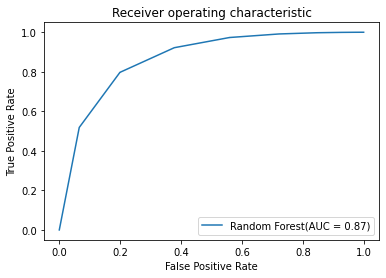

In [23]:
roc=roc_auc_score(y_test, model_rf.predict_proba(c)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, model_rf.predict_proba(c)[:,1],pos_label = 'positive')
plt.figure()
plt.plot(fpr, tpr, label='Random Forest(AUC = %0.2f)' % roc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()